<a href="https://colab.research.google.com/github/Imashish-45/Book-Recommendation/blob/main/Book_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

## Introduction to Collaborative Filtering-Based Book Recommendation System

Welcome to this notebook dedicated to creating a collaborative filtering-based book recommendation system! In today's digital landscape, the sheer volume of available books can make it challenging for users to discover new reads that align with their tastes. Collaborative filtering, a powerful technique employed by recommendation systems, addresses this challenge by analyzing user behaviors to provide insightful suggestions based on user similarities.

Collaborative filtering operates on the principle that users who share similar preferences in the past are likely to have similar preferences in the future. By analyzing user interactions, such as book ratings and preferences, we can uncover underlying patterns and relationships that allow us to suggest books that users are likely to enjoy.

**Key Features of Collaborative Filtering-Based Recommendation Systems:**

- **Personalized Recommendations**: Collaborative filtering excels at delivering personalized recommendations. It suggests books based on how similar users have rated and enjoyed items in the past, tailoring suggestions to each individual.

- **User and Item Discoverability**: This approach helps address the "cold start" problem where new users or books lack sufficient data for traditional recommendation methods. Collaborative filtering can still provide meaningful suggestions by identifying users with similar preferences.

- **Serendipity and Exploration**: Collaborative filtering encourages serendipity by exposing users to books they might not have discovered otherwise. It introduces variety and diversity into recommendations.

Throughout this notebook, we'll explore the mechanics behind collaborative filtering-based recommendation systems and guide you through the process of building one step by step. By the end of this journey, you'll have gained valuable insights into how collaborative filtering works and how it empowers us to create engaging book recommendations tailored to users' preferences.

So, let's embark on this exploration of collaborative filtering and unlock the potential of personalized book recommendations!

---



In [26]:
# Importing the libraries required:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno
from sklearn.metrics.pairwise import cosine_similarity

# Data Loading And Exploration:

In [25]:
rating = pd.read_csv("/content/Ratings.csv")
user = pd.read_csv("/content/Users.csv")
books = pd.read_csv("/content/Books.csv")

<ipython-input-25-e7128c5cb62b>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("/content/Books.csv")


In [3]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
user.shape

(278858, 3)

In [5]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [7]:
rating.duplicated().sum(

)

0

In [8]:
rating.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


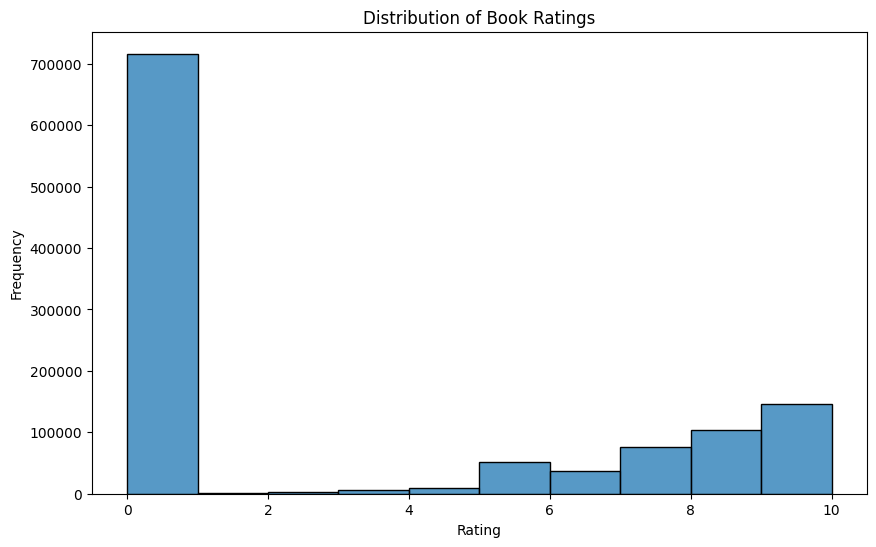

In [10]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(rating["Book-Rating"], bins=10, kde=False)
plt.title("Distribution of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()





In [11]:
rating['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

Inference: Users might be more likely to give either very positive (10) or very negative (0) ratings, leading to a skewed distribution.

In [12]:
# # Top Rated Books
top_rated_books = rating.groupby("ISBN")["Book-Rating"].mean().sort_values(ascending=False).head(10)
print("Top Rated Books:")
print(top_rated_books)

Top Rated Books:
ISBN
0874477050    10.0
561002010     10.0
0590939874    10.0
1570761914    10.0
56500624X     10.0
157076154X    10.0
1570761175    10.0
0373510365    10.0
0393092526    10.0
0590936026    10.0
Name: Book-Rating, dtype: float64


In [13]:
# # User Activity
user_activity = rating["User-ID"].value_counts()
print("User Activity:")
print(user_activity.describe())

User Activity:
count    105283.000000
mean         10.920851
std          90.562825
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       13602.000000
Name: User-ID, dtype: float64


In [14]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
user.shape

(278858, 3)

In [16]:
user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [17]:
user.duplicated().sum()

0

In [18]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [19]:
user.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


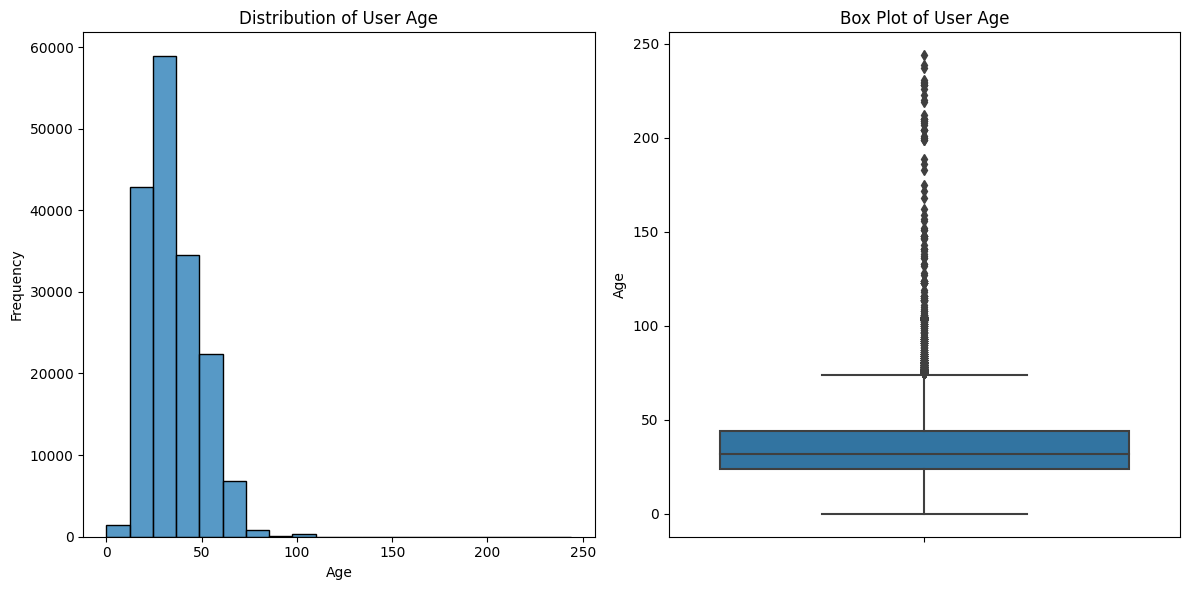

In [20]:
# Distribution of Age
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(user["Age"].dropna(), bins=20, kde=False)
plt.title("Distribution of User Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(y=user["Age"])
plt.title("Box Plot of User Age")
plt.ylabel("Age")

plt.tight_layout()
plt.show()

# print(user['Age'].value_counts())

In [21]:
user['Age'].value_counts()

24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
168.0       1
132.0       1
159.0       1
186.0       1
127.0       1
Name: Age, Length: 165, dtype: int64

In [22]:
user["Age"].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [23]:
# Top Locations
top_locations = user["Location"].value_counts().head(10)
print("Top Locations:")
print(top_locations)



Top Locations:
london, england, united kingdom        2506
toronto, ontario, canada               2250
sydney, new south wales, australia     1744
melbourne, victoria, australia         1708
portland, oregon, usa                  1629
chicago, illinois, usa                 1526
seattle, washington, usa               1484
new york, new york, usa                1411
madrid, madrid, spain                  1400
vancouver, british columbia, canada    1359
Name: Location, dtype: int64


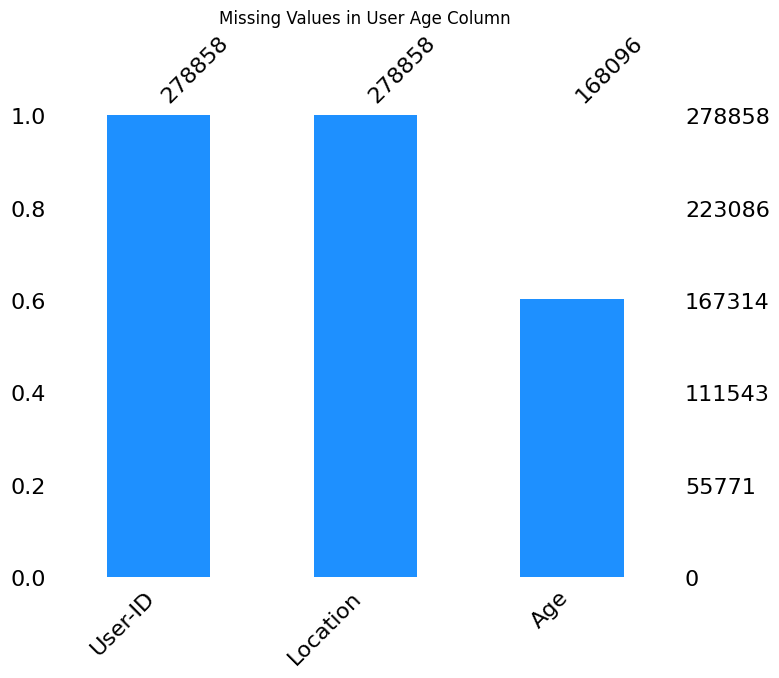

Missing Age Values: 110762


In [24]:
# Visualize missing values using missingno


plt.figure(figsize=(6, 4))
msno.bar(user, figsize=(8, 6), color='dodgerblue')
plt.title("Missing Values in User Age Column")
plt.show()


missing_age_count = user["Age"].isnull().sum()
print("Missing Age Values:", missing_age_count)

As we are working on recommendation system , Age columns doesnt need to be perfect.

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books['Image-URL-M'][1]

'http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg'

In [ ]:
books.shape

(271360, 8)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [ ]:
books.duplicated().sum()

0

Top Authors:
Axes(0.125,0.11;0.775x0.77)


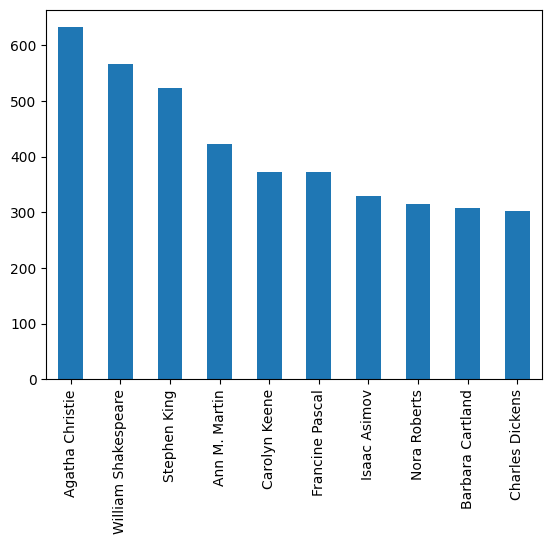

In [ ]:
# Top Authors
top_authors = books["Book-Author"].value_counts().head(10).plot(kind = "bar")
print("Top Authors:")
print(top_authors)

Top Publishers:
Axes(0.22375,0.11;0.5775x0.77)


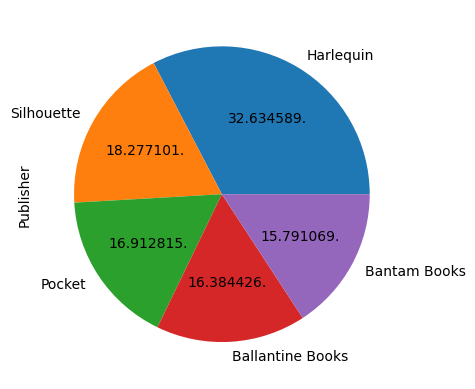

In [ ]:
# Top Publishers
top_publishers = books["Publisher"].value_counts().head(5).plot(kind = 'pie',autopct = '%2f.')
print("Top Publishers:")
print(top_publishers)

## Popularity Based Recommender System:

In [ ]:
book_rating= rating.merge(books,on='ISBN')

In [ ]:
num_rating = book_rating.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [ ]:
avg_rating= book_rating.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating

<ipython-input-41-5987f09c8f55>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rating= book_rating.groupby('Book-Title').mean()['Book-Rating'].reset_index()


,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241066,Ã?Â?lpiraten.,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,5.250000
241068,Ã?Â?sterlich leben.,7.000000
241069,Ã?Â?stlich der Berge.,2.666667


In [ ]:
popular_book = num_rating.merge(avg_rating,on='Book-Title')
popular_book

,Book-Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,Always Have Popsicles,1,0.000000
2,Apple Magic (The Collector's series),1,0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.000000
...,...,...,...
241066,Ã?Â?lpiraten.,2,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241068,Ã?Â?sterlich leben.,1,7.000000
241069,Ã?Â?stlich der Berge.,3,2.666667


In [ ]:
popular_book = popular_book[popular_book['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(50)

In [ ]:
popular_book.head()

,Book-Title,num_ratings,avg_rating
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
80441,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
80426,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
80414,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
popular_df = popular_book.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','num_ratings','avg_rating','Image-URL-M']]

In [ ]:
popular_df

,Book-Title,Book-Author,num_ratings,avg_rating,Image-URL-M
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,428,5.852804,http://images.amazon.com/images/P/0439136350.0...
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,387,5.824289,http://images.amazon.com/images/P/0439139597.0...
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,278,5.737410,http://images.amazon.com/images/P/0590353403.0...
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,347,5.501441,http://images.amazon.com/images/P/043935806X.0...
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,556,5.183453,http://images.amazon.com/images/P/0439064872.0...
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,281,5.007117,http://images.amazon.com/images/P/0345339681.0...
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,368,4.948370,http://images.amazon.com/images/P/0345339703.0...
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,575,4.895652,http://images.amazon.com/images/P/059035342X.0...
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,260,4.880769,http://images.amazon.com/images/P/0345339711.0...
39,To Kill a Mockingbird,Harper Lee,510,4.700000,http://images.amazon.com/images/P/0446310786.0...


# Collaborative Filtering Based Recommender System

In [ ]:
book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [ ]:
x = book_rating.groupby('User-ID').count()['Book-Rating'] > 200
active_user = x[x].index

In [ ]:
filtered_rating = book_rating[book_rating['User-ID'].isin(active_user)]

In [ ]:
filtered_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [ ]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [ ]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [ ]:
pivot_table = final_ratings.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating')

In [ ]:
pivot_table.head()

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pivot_table.fillna(0, inplace = True)

In [ ]:
pivot_table.head()

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Checking Similarity:**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similar_score = cosine_similarity(pivot_table)

In [ ]:
similar_score.shape

(706, 706)

# Recommendation System:

In [ ]:
def recommend(book_name):
    index = np.where(pivot_table.index == book_name)[0][0]

    similar_items = sorted(list(enumerate(similar_score[index])),key = lambda x:x[1], reverse = True)[1:6]

    data = []

    for i in similar_items:
        item = []

        temp_df = books[books['Book-Title'] == pivot_table.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

        data.append(item)

    return data



# **Testing:**

In [ ]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg'],
 ['The Hours : A Novel',
  'Michael Cunningham',
  'http://images.amazon.com/images/P/0312243022.01.MZZZZZZZ.jpg']]

In [ ]:
books.drop_duplicates('Book-Title')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271354,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


# Pickling the Models and Dataframes:

In [ ]:
import pickle
pickle.dump(popular_df,open('popular.pkl','wb'))

In [ ]:
pickle.dump(pivot_table,open('pt.pkl','wb'))
pickle.dump(books,open('books.pkl','wb'))
pickle.dump(similar_score,open('similarity_scores.pkl','wb'))

In [ ]:
pickle.dump(similar_score,open('similar_scores.pkl','wb'))